In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

C:\Users\tnemeth\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



# Trainable segmentation using local features and random forests

A pixel-based segmentation is computed here using local features based on
local intensity, edges and textures at different scales. A user-provided
mask is used to identify different regions. The pixels of the mask are used
to train a random-forest classifier [1]_ from scikit-learn. Unlabeled pixels
are then labeled from the prediction of the classifier.

This segmentation algorithm is called trainable segmentation in other software
such as ilastik [2]_ or ImageJ [3]_ (where it is also called "weka
segmentation").

.. [1] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
.. [2] https://www.ilastik.org/documentation/pixelclassification/pixelclassification
.. [3] https://imagej.net/Trainable_Weka_Segmentation#Training_features_.282D.29


C:\Users\tnemeth\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


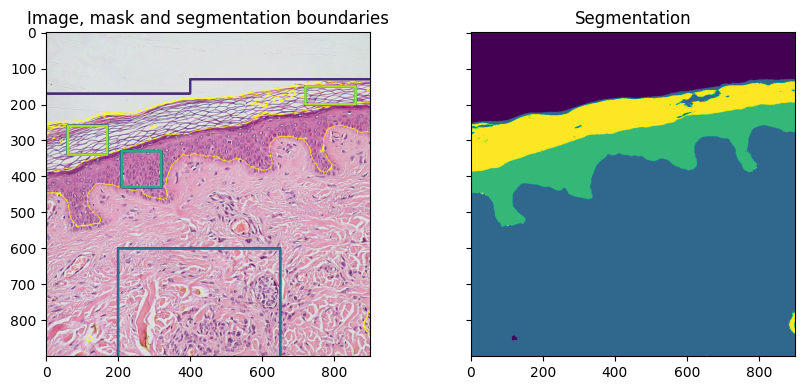

In [1]:
full_img = data.skin()

img = full_img[:900, :900]

# Build an array of labels for training the segmentation.
# Here we use rectangles but visualization libraries such as plotly
# (and napari?) can be used to draw a mask on the image.
training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
training_labels[:130] = 1
training_labels[:170, :400] = 1
training_labels[600:900, 200:650] = 2
training_labels[330:430, 210:320] = 3
training_labels[260:340, 60:170] = 4
training_labels[150:200, 720:860] = 4

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result)
ax[1].set_title('Segmentation')
fig.tight_layout()

## Feature importance

We inspect below the importance of the different features, as computed by
scikit-learn. Intensity features have a much higher importance than texture
features. It can be tempting to use this information to reduce the number of
features given to the classifier, in order to reduce the computing time.
However, this can lead to overfitting and a degraded result at the boundary
between regions.



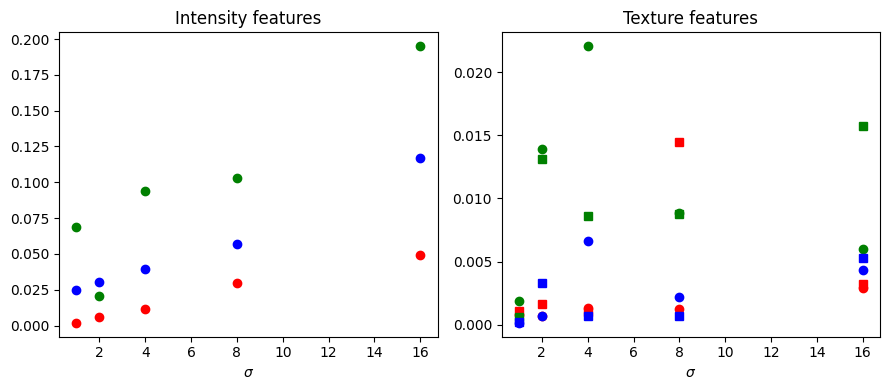

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
l = len(clf.feature_importances_)
feature_importance = (
        clf.feature_importances_[:l//3],
        clf.feature_importances_[l//3:2*l//3],
        clf.feature_importances_[2*l//3:])
sigmas = np.logspace(
        np.log2(sigma_min), np.log2(sigma_max),
        num=int(np.log2(sigma_max) - np.log2(sigma_min) + 1),
        base=2, endpoint=True)
for ch, color in zip(range(3), ['r', 'g', 'b']):
    ax[0].plot(sigmas, feature_importance[ch][::3], 'o', color=color)
    ax[0].set_title("Intensity features")
    ax[0].set_xlabel("$\\sigma$")
for ch, color in zip(range(3), ['r', 'g', 'b']):
    ax[1].plot(sigmas, feature_importance[ch][1::3], 'o', color=color)
    ax[1].plot(sigmas, feature_importance[ch][2::3], 's', color=color)
    ax[1].set_title("Texture features")
    ax[1].set_xlabel("$\\sigma$")

fig.tight_layout()

## Fitting new images

If you have several images of similar objects acquired in similar conditions,
you can use the classifier trained with `fit_segmenter` to segment other
images. In the example below we just use a different part of the image.



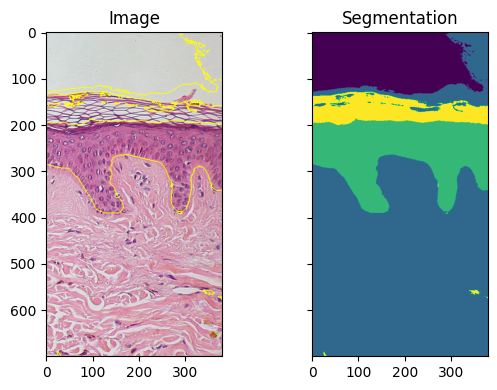

In [3]:
img_new = full_img[:700, 900:]

features_new = features_func(img_new)
result_new = future.predict_segmenter(features_new, clf)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 4))
ax[0].imshow(segmentation.mark_boundaries(img_new, result_new, mode='thick'))
ax[0].set_title('Image')
ax[1].imshow(result_new)
ax[1].set_title('Segmentation')
fig.tight_layout()

plt.show()


---


# Applying Method to IU Data

### Get Slice to Test

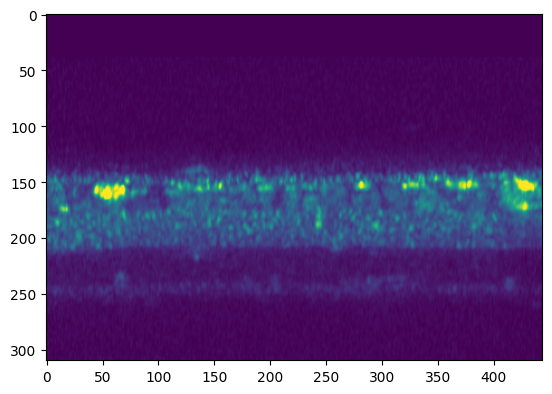

In [2]:
from skimage import io as skio

filepath = "iu_test_data.tif"
iu_bscan_data = skio.imread(filepath)

test_slice = iu_bscan_data[170,:310,:]

# Data format = [z, y, x]
#print(len(iu_bscan_data[:,0,0]))
#print(len(iu_bscan_data[0,:,0]))
#print(len(iu_bscan_data[0,0,:]))

plt.imshow(test_slice)

### Add rough labels

In [3]:
# Build an array of labels for training the segmentation.
training_labels = np.zeros(test_slice.shape, dtype=np.uint8)
training_labels[:140, :] = 1 # Nonlayer
training_labels[140:175, :] = 2 # GCL
training_labels[175:210, :] = 3 # IPL
training_labels[210:240, :] = 4 # INL
training_labels[240:255, :] = 5 # OPL
training_labels[255:, :] = 1 # Nonlayer

Note: looking at the example training data, it looks like boxes define regions that are only part of the correct region. The above labels are more coarse, so results might be improved by narrowing the label regions

### Train on test slice

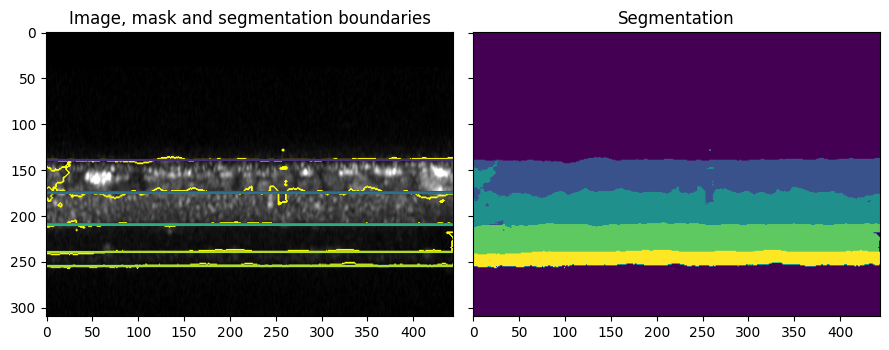

In [6]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=True, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=None)
features = features_func(test_slice)
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(test_slice, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result)
ax[1].set_title('Segmentation')
fig.tight_layout()

Note: We can improve model accuracy by increasing the number of decision trees (n_estimators). This will be more computationally demanding, but this is not a problem if we can use the GPU

### Test trained model on new data

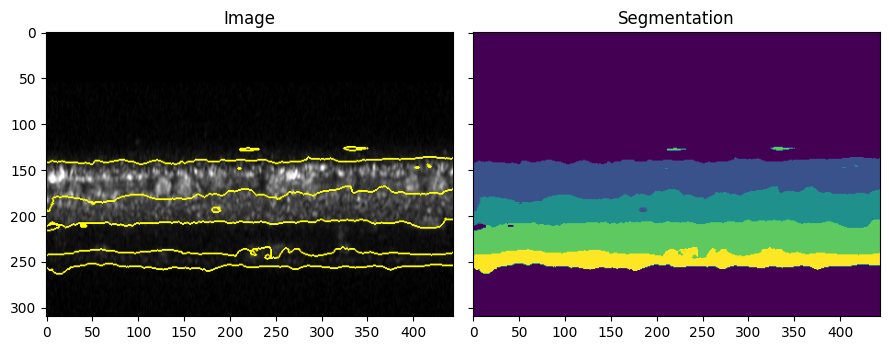

In [7]:
new_slice = iu_bscan_data[329,:310,:]

features_new = features_func(new_slice)
result_new = future.predict_segmenter(features_new, clf)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(new_slice, result_new, mode='thick'))
ax[0].set_title('Image')
ax[1].imshow(result_new)
ax[1].set_title('Segmentation')
fig.tight_layout()

plt.show()

#### The above slice is a fairly standard bscan, so the model performs relatively well. But, it struggles in the presence of large vessels and shadows. This can be solved by increasing the training data set

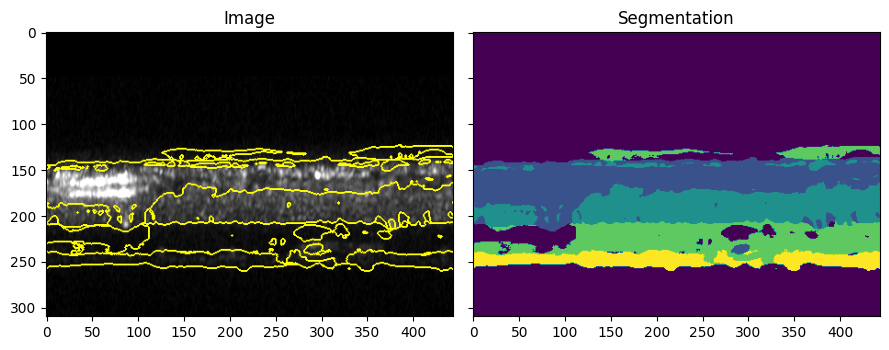

In [47]:
new_slice = iu_bscan_data[284,:310,:]

features_new = features_func(new_slice)
result_new = future.predict_segmenter(features_new, clf)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(new_slice, result_new, mode='thick'))
ax[0].set_title('Image')
ax[1].imshow(result_new)
ax[1].set_title('Segmentation')
fig.tight_layout()

plt.show()

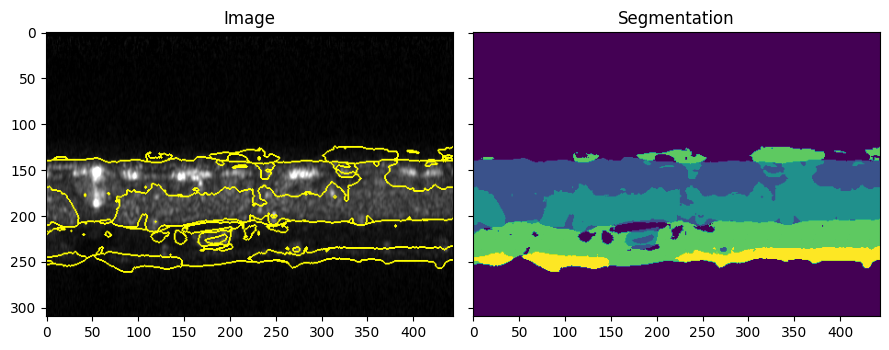

In [48]:
new_slice = iu_bscan_data[0,:310,:]

features_new = features_func(new_slice)
result_new = future.predict_segmenter(features_new, clf)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(new_slice, result_new, mode='thick'))
ax[0].set_title('Image')
ax[1].imshow(result_new)
ax[1].set_title('Segmentation')
fig.tight_layout()

plt.show()

### Measure Error

### Next Steps

Link to a helpful guide on working with Random Forest Classifiers: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

* Use model to predict on test data
* Evaluate predictions
* Correct predictions and use as additional training data
* Repeat